In [1]:
import pandas as pd
import requests
import time
import re
import matplotlib.pyplot as plt
import csv
import os

from bs4 import BeautifulSoup

In [2]:
def is_page_empty(bs) -> bool:
    empty_condition = bs.find('h2', class_='text-white font-weight-bold')

    if empty_condition is None:
        return False
    else:
        return True

In [17]:
def parse_salary(salary) -> dict:
    bounds = re.findall('[0-9]+', salary.replace(' ', ''))
    low_bound = bounds[0]
    high_bound = bounds[1] if len(bounds) > 1 else bounds[0]
    currency = salary.split()[-1]

    return {'low': low_bound,
            'high': high_bound,
            'currency': currency}

In [4]:
def parse_city(city) -> dict:
    if re.search('(Zdalna)', city):
         _city = "Zdalna"
         country = 'N/A'
    else:       
        (_city, country) = city.split(',')
        country = re.sub('\\n +.*', '', country).strip()

    return {'city': _city, 'country': country}

In [5]:
def parse_jobs(jobs) -> list:
    results = []
    
    for job in jobs:
        results.append(parse_job(job))

    return results

In [6]:
def parse_job(job) -> dict:
    job_info = job.find('div', class_='posting-info position-relative d-none d-lg-flex flex-grow-1').find_all('span')
    
    salary = job_info[0].text.strip()
    salary_data = parse_salary(salary)
    
    location = job.find('nfj-posting-item-city')
    if location is None:
        location = job_info[1]

    location = location.text.strip()
    location = parse_city(location)

    name = job.find('h3', class_='posting-title__position').text.strip()
    company = job.find('span', class_='posting-title__company').text.replace('w', '').strip()

    technology = job.find('a', class_='btn btn-outline-secondary btn-sm text-truncate')
    if technology:
        technology = technology.text.strip()
    else:
        technology = 'N/A'

    return {
        'location': location,
        'salary': salary_data,
        'name': name,
        'company': company,
        'technology': technology
    } 

In [11]:
def get_data(page) -> list:
    results = []

    jobs = [x.parent for x in page.find_all('div', class_='posting-image')]
    page_data = parse_jobs(jobs)
    results += page_data

    return results

In [40]:
data_dir = '../data/raw'
results = []

for entry in os.scandir(data_dir):
    with open(
        os.path.join(data_dir, entry.name),
        encoding='UTF-8') as f:
            html = f.read()

    job = entry.name.split('_')[0]
    bs = BeautifulSoup(html)
    
    offers = get_data(bs)
    for offer in offers:
        offer['job'] = job
    results += offers

In [42]:
df_raw = pd.json_normalize(results, sep='_')
df_raw.head()

,name,company,technology,job,location_city,location_country,salary_low,salary_high,salary_currency
0,UX/UI Designer,HL Tech,N/A,data analyst,Warsaw,POL,6500,9500,PLN
1,Power BI Data Analyst,Devire,N/A,data analyst,warszawa,POL,13440,16800,PLN
2,Data Analyst,IIIT,N/A,data analyst,Warszawa,POL,8000,12000,PLN
3,Senior Data Analyst,Devire,N/A,data analyst,Zdalna,N/A,16800,20160,PLN
4,Office Manager,Prime Force,N/A,data analyst,Warsaw,POL,3500,6500,PLN


In [43]:
df_raw.groupby(by=['technology']).size().sort_values(ascending=False)

technology
N/A                     54
python                  21
spark                    8
SQL                      4
azure                    3
Apigee                   3
scala                    3
java                     3
aws                      2
hadoop                   2
AWS                      2
Ansible                  1
cloud                    1
Shell/Bash               1
ios                      1
Python / Java / .NET     1
javascript               1
Python                   1
react                    1
ruby on rails            1
Pandas                   1
Data Science             1
sql                      1
dtype: int64

In [6]:
df_raw.groupby(by=['location_country']).size().sort_values(ascending=False)

location_country
N/A    71
POL    63
HUN     7
dtype: int64

In [7]:
df = df_raw.query('location_country == "POL"')
df.loc[df['location_city'] == 'Warsaw', 'location_city'] = 'Warszawa'

<AxesSubplot:xlabel='technology'>

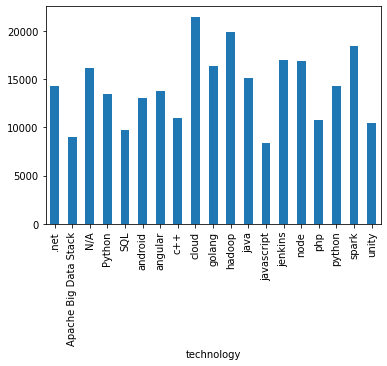

In [8]:
df.groupby(by=['technology'])['salary_avg'].mean().plot.bar()

<AxesSubplot:ylabel='None'>

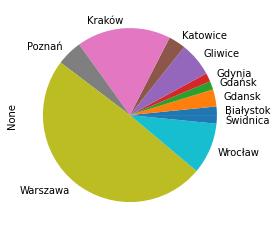

In [9]:
df.query('location_city != "Zdalna"').groupby(by=['location_city']).size().plot.pie()

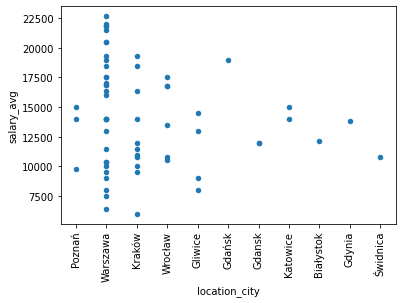

In [10]:
df.plot.scatter(x='location_city', y='salary_avg')
plt.xticks(rotation=90)
plt.show()

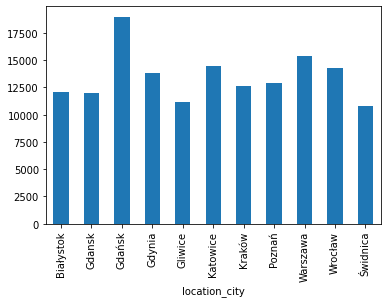

In [11]:
df.query('location_country == "POL"').groupby(by=['location_city'])['salary_avg'].mean().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [12]:
miasta = csv.reader(open(r"raw\miasta.csv"))
cities = {}
for row in miasta:
    cities[row[0]] = {'latitude': row[1], 'longitude': row[2]}

In [13]:
cities_df = pd.read_csv("raw\miasta.csv", encoding="ANSI", header=None)
cities_df.columns = ['city', 'latitude', 'longitude']

cities_df['latitude'] = pd.to_numeric(cities_df['latitude'])
cities_df['longitude'] = pd.to_numeric(cities_df['longitude'])

In [14]:
df = pd.merge(
    left=df,
    right=cities_df,
    left_on=['location_city'],
    right_on='city'
)
df.drop(columns=['city'], inplace=True)

In [15]:
df_map = df.groupby(by=['location_city', 'latitude', 'longitude'], as_index=False).size()
df_map.rename(columns={'size': 'count'}, inplace=True)

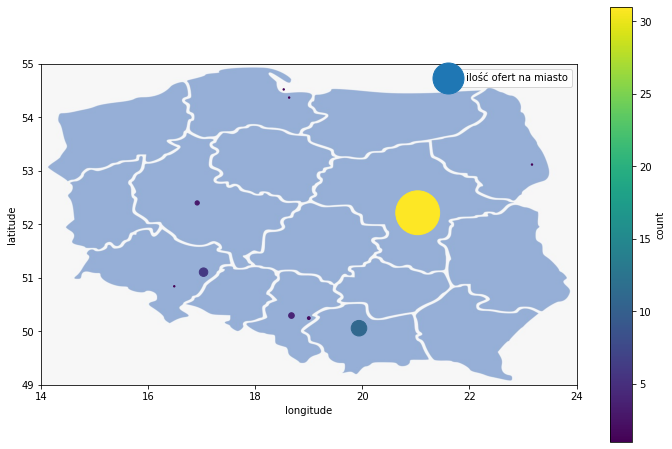

In [16]:
# Tworzymy przestrzeń dla wykresu
plt.figure(figsize=(12,8))
 
# Wczytujemy obraz i umieszczamy go na wykresie w miejscu extent=[x1, x2, y1, y2]
image = plt.imread(r'raw\mapa_polski.jpg')
plt.imshow(
    image, 
    zorder=0,   # mówimy, że mapa będzie leżała na samym dole wykresu  https://matplotlib.org/3.1.1/gallery/misc/zorder_demo.html 
    extent=[14, 24, 49, 55]
    )
 
# Tworzymy osie i rysujemy wykres znanym już nam poleceniem scatter.plot(). Następnie tworzymy legendę i wyświetlamy wykres.
ax=plt.gca()  # pobiera aktualny ax, na którym pracujemy
df_map.plot.scatter(
    x='longitude', 
    y='latitude', 
    label='ilość ofert na miasto', 
    c='count', 
    ax=ax,
    s=2 * df_map['count']**2,  # określamy wielkość punktu
    cmap='viridis'  # określamy paletę kolorów https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
    )
            
plt.legend()